In [528]:
from scipy.spatial import Delaunay
import pandas as pd
import numpy as np

In [529]:
my_data = pd.read_csv('my_data.csv')
print(my_data.head())

points = np.vstack((my_data['x2'], my_data['y2'])).T
tri = Delaunay(points)

         q1        q2        x2        y2
0 -1.570796 -1.047198 -0.866025 -1.500000
1 -1.517368 -1.047198 -0.784685 -1.544108
2 -1.463939 -1.047198 -0.701105 -1.583809
3 -1.410511 -1.047198 -0.615525 -1.618990
4 -1.357083 -1.047198 -0.528187 -1.649551


In [530]:
def is_inside_workspace(point):
    return tri.find_simplex(point) >= 0


In [531]:
import tensorflow as tf
from keras.api.models import load_model

In [532]:
def mdn_loss(y_true, y_pred):
    n_components = 2
    n_dims = 2

    # Split model outputs and process outputs
    out_pi = y_pred[:, :n_components]
    out_mu = y_pred[:, n_components:n_components + n_components * n_dims]
    out_sigma = y_pred[:, n_components + n_components * n_dims:]

    pi = tf.nn.softmax(out_pi)
    mu = tf.reshape(out_mu, [-1, n_components, n_dims])
    sigma = tf.exp(out_sigma)
    sigma = tf.reshape(sigma, [-1, n_components, n_dims])

    y_true_exp = tf.reshape(y_true, [-1, 1, n_dims])

    # Normalized difference
    norm = (y_true_exp - mu) / sigma

    # Exponent term
    exponent = -0.5 * tf.reduce_sum(tf.square(norm), axis=2)

    # Normalizing coefficient
    coeff = 1.0 / (2.0 * np.pi * tf.reduce_prod(sigma, axis=2))

    # Gaussian component density
    gauss = coeff * tf.exp(exponent)

    
    weighted = pi * gauss
    total_prob = tf.reduce_sum(weighted, axis=1) + 1e-8

    loss = -tf.math.log(total_prob)
    return tf.reduce_mean(loss)


In [533]:
def decode_mdn_output(pred):
    n_components = 2
    n_dims = 2

    pi_logits = pred[:, :n_components]
    pi = tf.nn.softmax(pi_logits).numpy()

    mu = pred[:, n_components:n_components + n_components * n_dims]
    mu = mu.reshape(-1, n_components, n_dims)

    sigma = pred[:, n_components + n_components * n_dims:]
    sigma = np.exp(sigma).reshape(-1, n_components, n_dims)

    return pi, mu, sigma


path = 'models\my_mdn_model_100_100.keras'
model = load_model(path, custom_objects={'mdn_loss': mdn_loss})


In [534]:
def forward_kinematics_np(q):
    L1 = 1.0
    L2 = 1.0
    q1 = q[:, 0]
    q2 = q[:, 1]
    x1 = L1 * np.cos(q1)
    y1 = L1 * np.sin(q1)
    x2 = x1 + L2 * np.cos(q1 + q2)
    y2 = y1 + L2 * np.sin(q1 + q2)

    return x1, y1, x2, y2

In [535]:
import matplotlib.pyplot as plt

def plot_robot(q1, q2, color='red', label='Predicted'):
    L1 = 1.0
    L2 = 1.0
    x1 = L1 * np.cos(q1)
    y1 = L1 * np.sin(q1)
    x2 = x1 + L2 * np.cos(q1 + q2)
    y2 = y1 + L2 * np.sin(q1 + q2)
    plt.plot([0, x1, x2], [0, y1, y2], color=color, marker='o', label=label)
    plt.axis('equal')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


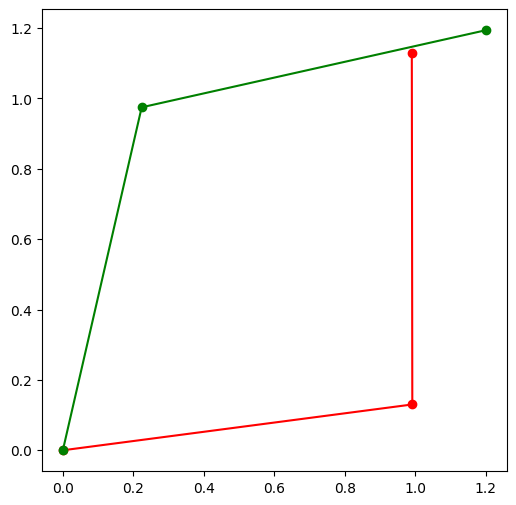

In [536]:
point = np.array([[0.9, 1.2]])
pred = model.predict(point)
pi, mu, sigma = decode_mdn_output(pred)

plt.figure(figsize=(6, 6))
plot_robot(mu[0,0,0], mu[0,0,1], color='red')
plot_robot(mu[0,1,0], mu[0,1,1], color='green')

In [537]:
def define_elbow(q):
    x1,y1,x2,y2 = forward_kinematics_np(q)
    phi1 = np.arctan2((y1-0), (x1-0))
    phi2 = np.arctan2((y2-y1), (x2-x1))
    return 'up' if (phi1>phi2) > 0 else 'down'


test1 = define_elbow(np.array([[mu[0,0,0], mu[0,0,1]]]))
print(test1)
test2 = define_elbow(np.array([[mu[0,1,0], mu[0,1,1]]]))
print(test2)

down
up


In [538]:
from scipy.interpolate import make_interp_spline

In [539]:
waypoints = np.array([
    [0.5, -1.75],
    [0.7, -1.6],
    [0.9, -1.2],
    [1.0, -1.5]
])

deltas = np.diff(waypoints, axis=0)
distances = np.linalg.norm(deltas, axis=1)
t = np.concatenate([[0], np.cumsum(distances)])

x = waypoints[:, 0].reshape(-1,1)
y = waypoints[:, 1].reshape(-1,1)

x_spline = make_interp_spline(t, x)
y_spline = make_interp_spline(t, y)
t_fine = np.linspace(t[0], t[-1], 100)
x_path = x_spline(t_fine)
y_path = y_spline(t_fine)

All points are inside the workspace.


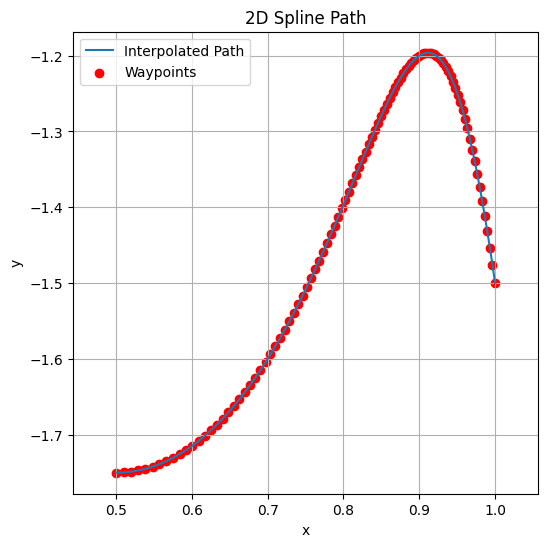

In [540]:
path = np.hstack((x_path, y_path))
result = is_inside_workspace(path)

if not np.all(result):
    print("At least one point is outside the workspace.")
else:
    print("All points are inside the workspace.")

plt.figure(figsize=(6,6))
plt.plot(path[:, 0], path[:, 1], label='Interpolated Path')
plt.scatter(path[:, 0], path[:, 1], color='red', label='Waypoints')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Spline Path')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Keeps scale correct for robot motion
plt.show()

In [541]:
pred_path = model.predict(path)
pi_path, mu_path, sigma_path = decode_mdn_output(pred_path)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [542]:
from scipy.spatial import Delaunay
import pandas as pd
import numpy as np

In [543]:
my_data = pd.read_csv('my_data.csv')
print(my_data.head())

points = np.vstack((my_data['x2'], my_data['y2'])).T
tri = Delaunay(points)

         q1        q2        x2        y2
0 -1.570796 -1.047198 -0.866025 -1.500000
1 -1.517368 -1.047198 -0.784685 -1.544108
2 -1.463939 -1.047198 -0.701105 -1.583809
3 -1.410511 -1.047198 -0.615525 -1.618990
4 -1.357083 -1.047198 -0.528187 -1.649551


In [544]:
def is_inside_workspace(point):
    return tri.find_simplex(point) >= 0


In [545]:
import tensorflow as tf
from keras.api.models import load_model

In [546]:
def mdn_loss(y_true, y_pred):
    n_components = 2
    n_dims = 2

    # Split model outputs and process outputs
    out_pi = y_pred[:, :n_components]
    out_mu = y_pred[:, n_components:n_components + n_components * n_dims]
    out_sigma = y_pred[:, n_components + n_components * n_dims:]

    pi = tf.nn.softmax(out_pi)
    mu = tf.reshape(out_mu, [-1, n_components, n_dims])
    sigma = tf.exp(out_sigma)
    sigma = tf.reshape(sigma, [-1, n_components, n_dims])

    y_true_exp = tf.reshape(y_true, [-1, 1, n_dims])

    # Normalized difference
    norm = (y_true_exp - mu) / sigma

    # Exponent term
    exponent = -0.5 * tf.reduce_sum(tf.square(norm), axis=2)

    # Normalizing coefficient
    coeff = 1.0 / (2.0 * np.pi * tf.reduce_prod(sigma, axis=2))

    # Gaussian component density
    gauss = coeff * tf.exp(exponent)

    
    weighted = pi * gauss
    total_prob = tf.reduce_sum(weighted, axis=1) + 1e-8

    loss = -tf.math.log(total_prob)
    return tf.reduce_mean(loss)


In [547]:
def decode_mdn_output(pred):
    n_components = 2
    n_dims = 2

    pi_logits = pred[:, :n_components]
    pi = tf.nn.softmax(pi_logits).numpy()

    mu = pred[:, n_components:n_components + n_components * n_dims]
    mu = mu.reshape(-1, n_components, n_dims)

    sigma = pred[:, n_components + n_components * n_dims:]
    sigma = np.exp(sigma).reshape(-1, n_components, n_dims)

    return pi, mu, sigma


path = 'models\my_mdn_model_100_100.keras'
model = load_model(path, custom_objects={'mdn_loss': mdn_loss})


In [548]:
def forward_kinematics_np(q):
    L1 = 1.0
    L2 = 1.0
    q1 = q[:, 0]
    q2 = q[:, 1]
    x1 = L1 * np.cos(q1)
    y1 = L1 * np.sin(q1)
    x2 = x1 + L2 * np.cos(q1 + q2)
    y2 = y1 + L2 * np.sin(q1 + q2)

    return x1, y1, x2, y2

In [549]:
import matplotlib.pyplot as plt

def plot_robot(q1, q2, color='red', label='Predicted'):
    L1 = 1.0
    L2 = 1.0
    x1 = L1 * np.cos(q1)
    y1 = L1 * np.sin(q1)
    x2 = x1 + L2 * np.cos(q1 + q2)
    y2 = y1 + L2 * np.sin(q1 + q2)
    plt.plot([0, x1, x2], [0, y1, y2], color=color, marker='o', label=label)
    plt.axis('equal')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


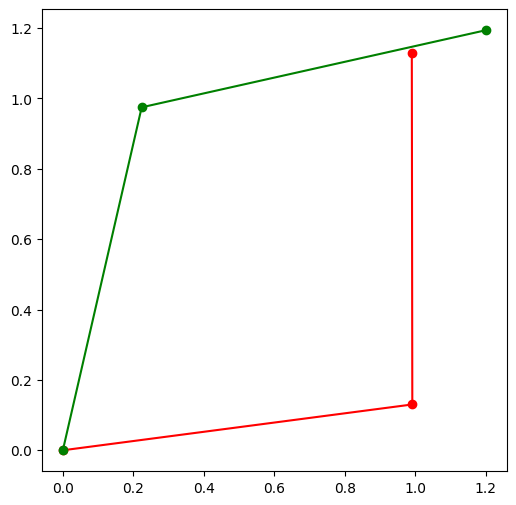

In [550]:
point = np.array([[0.9, 1.2]])
pred = model.predict(point)
pi, mu, sigma = decode_mdn_output(pred)

plt.figure(figsize=(6, 6))
plot_robot(mu[0,0,0], mu[0,0,1], color='red')
plot_robot(mu[0,1,0], mu[0,1,1], color='green')

In [551]:
def define_elbow(q):
    x1,y1,x2,y2 = forward_kinematics_np(q)
    phi1 = np.arctan2((y1-0), (x1-0))
    phi2 = np.arctan2((y2-y1), (x2-x1))
    return 'up' if (phi1>phi2) > 0 else 'down'


test1 = define_elbow(np.array([[mu[0,0,0], mu[0,0,1]]]))
print(test1)
test2 = define_elbow(np.array([[mu[0,1,0], mu[0,1,1]]]))
print(test2)

down
up


In [552]:
from scipy.interpolate import make_interp_spline

In [553]:
waypoints = np.array([
    [0.5, -1.75],
    [0.7, -1.6],
    [0.9, -1.2],
    [1.0, -1.5]
])

deltas = np.diff(waypoints, axis=0)
distances = np.linalg.norm(deltas, axis=1)
t = np.concatenate([[0], np.cumsum(distances)])

x = waypoints[:, 0].reshape(-1,1)
y = waypoints[:, 1].reshape(-1,1)

x_spline = make_interp_spline(t, x)
y_spline = make_interp_spline(t, y)
t_fine = np.linspace(t[0], t[-1], 100)
x_path = x_spline(t_fine)
y_path = y_spline(t_fine)

All points are inside the workspace.


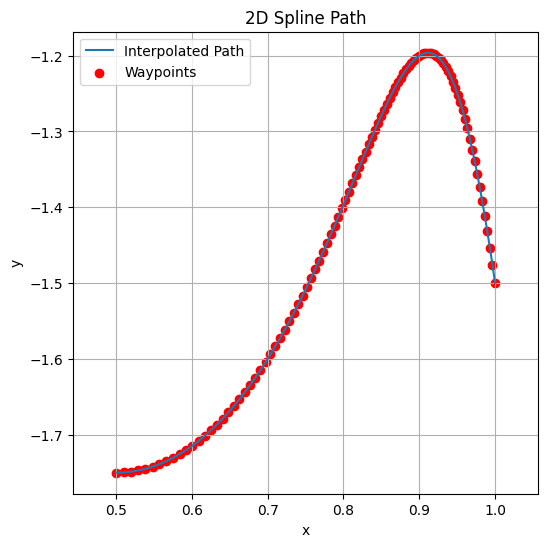

In [554]:
path = np.hstack((x_path, y_path))
result = is_inside_workspace(path)

if not np.all(result):
    print("At least one point is outside the workspace.")
else:
    print("All points are inside the workspace.")

plt.figure(figsize=(6,6))
plt.plot(path[:, 0], path[:, 1], label='Interpolated Path')
plt.scatter(path[:, 0], path[:, 1], color='red', label='Waypoints')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Spline Path')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Keeps scale correct for robot motion
plt.show()

In [555]:
pred_path = model.predict(path)
pi_path, mu_path, sigma_path = decode_mdn_output(pred_path)

elbow_config_0 = [define_elbow(np.array([q])) for q in mu_path[:, 0, :]]
elbow_config_1 = [define_elbow(np.array([q])) for q in mu_path[:, 1, :]]

# Compute forward kinematics for each sample in both modes
fk_outputs_0 = [forward_kinematics_np(np.array([q])) for q in mu_path[:, 0, :]]
fk_outputs_1 = [forward_kinematics_np(np.array([q])) for q in mu_path[:, 1, :]]


elbow_0 = np.array([[x1[0], y1[0]] for x1, y1, x2, y2 in fk_outputs_0])
wrist_0 = np.array([[x2[0], y2[0]] for x1, y1, x2, y2 in fk_outputs_0])

elbow_1 = np.array([[x1[0], y1[0]] for x1, y1, x2, y2 in fk_outputs_1])
wrist_1 = np.array([[x2[0], y2[0]] for x1, y1, x2, y2 in fk_outputs_1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [556]:
def inverse_kinematics_2link(x, y, L1=1.0, L2=1.0):
    D = (x**2 + y**2 - L1**2 - L2**2) / (2 * L1 * L2)
    if np.abs(D) > 1:
        return None  # unreachable

    q2_down = np.arctan2(np.sqrt(1 - D**2), D)
    q2_up = np.arctan2(-np.sqrt(1 - D**2), D)

    def q1(q2):  # helper
        k1 = L1 + L2 * np.cos(q2)
        k2 = L2 * np.sin(q2)
        return np.arctan2(y, x) - np.arctan2(k2, k1)

    return [(q1(q2_down), q2_down), (q1(q2_up), q2_up)]

true_elbow_down = []
true_wrist_down = []

true_elbow_up = []
true_wrist_up = []

for pt in path:
    sol = inverse_kinematics_2link(pt[0], pt[1])
    if sol is not None:
        (q1_down, q2_down), (q1_up, q2_up) = sol

        # Elbow-down
        x1d, y1d, x2d, y2d = forward_kinematics_np(np.array([[q1_down, q2_down]]))
        true_elbow_down.append([x1d[0], y1d[0]])
        true_wrist_down.append([x2d[0], y2d[0]])

        # Elbow-up
        x1u, y1u, x2u, y2u = forward_kinematics_np(np.array([[q1_up, q2_up]]))
        true_elbow_up.append([x1u[0], y1u[0]])
        true_wrist_up.append([x2u[0], y2u[0]])
    else:
        true_elbow_down.append([np.nan, np.nan])
        true_wrist_down.append([np.nan, np.nan])
        true_elbow_up.append([np.nan, np.nan])
        true_wrist_up.append([np.nan, np.nan])

true_elbow_down = np.array(true_elbow_down)
true_wrist_down = np.array(true_wrist_down)

true_elbow_up = np.array(true_elbow_up)
true_wrist_up = np.array(true_wrist_up)



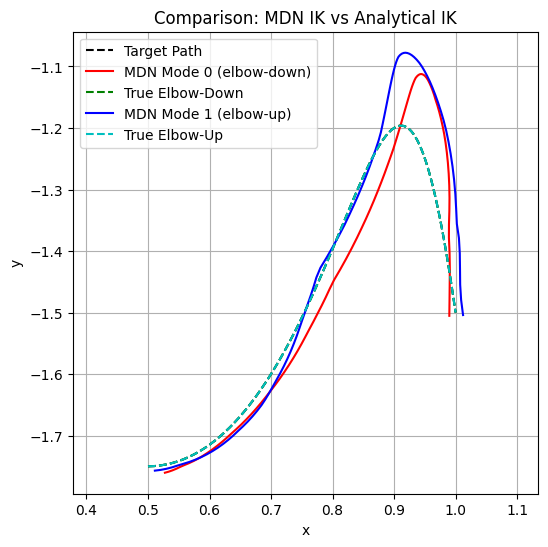

In [557]:
plt.figure(figsize=(6,6))
plt.plot(path[:,0], path[:,1], 'k--', label='Target Path')
plt.plot(wrist_0[:,0], wrist_0[:,1], 'r-', label='MDN Mode 0 (elbow-down)')
plt.plot(true_wrist_down[:,0], true_wrist_down[:,1], 'g--', label='True Elbow-Down')

plt.plot(wrist_1[:,0], wrist_1[:,1], 'b-', label='MDN Mode 1 (elbow-up)')
plt.plot(true_wrist_up[:,0], true_wrist_up[:,1], 'c--', label='True Elbow-Up')

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.title("Comparison: MDN IK vs Analytical IK")
plt.show()